# BlueSeis BSPF Event Selection

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client

from functions.request_data import __request_data
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __get_stream_6c(tbeg, tend, status=False):

    from functions.request_data import __request_data
    from functions.compute_adr_pfo import __compute_adr_pfo
    from obspy import UTCDateTime

    tbeb, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    try:
        ##load rotation
        bspf0, bspf_inv = __request_data("PY.BSPF..HJ*", tbeg-100, tend+100)
        # bspf0 = bspf0.resample(40, no_filter=False);

        # bspf0 = bspf0.detrend("linear").taper(0.01).filter("lowpass", freq=18.0, corners=4, zerophase=True)
        # bspf0 = bspf0.decimate(5, no_filter=True) ## 200 -> 40 Hz
        # bspf0 = bspf0.decimate(2, no_filter=True) ## 40 -> 20 Hz
        # bspf0 = bspf0.trim(tbeg, tend)

        ## load translation
        if tbeg > UTCDateTime("2023-04-02"):
            pfo0, pfo_inv = __request_data("PY.PFOIX..HH*", tbeg-100, tend+100, translation_type="ACC")
            # pfo0 = pfo0.resample(40, no_filter=False);

            # pfo0 = pfo0.detrend("linear").taper(0.01).filter("lowpass", freq=18.0, corners=4, zerophase=True)
            # pfo0 = pfo0.decimate(5, no_filter=True) ## 200 -> 40 Hz
            # pfo0 = pfo0.decimate(2, no_filter=True) ## 40 -> 20 Hz
            # pfo0 = pfo0.trim(tbeg, tend)

        else:
            pfo0, pfo_inv = __request_data("II.PFO.10.BH*", tbeg-100, tend+100, translation_type="ACC")
            # pfo0 = pfo0.resample(40, no_filter=False);

            # pfo0 = pfo0.detrend("linear").taper(0.01).filter("lowpass", freq=18.0, corners=4, zerophase=True)
            # pfo0 = pfo0.decimate(2, no_filter=True) ## 40 -> 20 Hz
            # pfo0 = pfo0.trim(tbeg, tend])
    except:
        pass

    # merge to one stream
    st0 = bspf0.copy();
    st0 += pfo0.copy();

    st0 = st0.sort();

    st0 = st0.trim(tbeg, tend);

    return st0

## Configurations

In [4]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"BSPF/figures/"


## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643


name = "M30"
config['tbeg'] = obs.UTCDateTime("2024-02-27 22:50:50")
config['tend'] = obs.UTCDateTime("2024-02-27 22:51:20")

# config['fmin'] = 1
# config['fmax'] = 5.0

In [5]:
events = {0 : {"tbeg": obs.UTCDateTime("2022-10-01 05:36:11"),
              "tend": obs.UTCDateTime("2022-10-01 05:36:41"),
              "trim": (3, 21),
             },
          1 : {"tbeg": obs.UTCDateTime("2022-10-02 03:25:16"),
              "tend": obs.UTCDateTime("2022-10-02 03:25:50"),
              "trim": (3, 26),
             },
          2 : {"tbeg": obs.UTCDateTime("2023-09-11 09:20:10"),
              "tend": obs.UTCDateTime("2023-09-11 09:20:30"),
              "trim": (6, 7),
             },
          3 : {"tbeg": obs.UTCDateTime("2023-03-01 22:49:03"),
              "tend": obs.UTCDateTime("2023-03-01 22:50:03"),
              "trim": (0, 49),
             },
          4 : {"tbeg": obs.UTCDateTime("2022-10-26 08:14:33"),
              "tend": obs.UTCDateTime("2022-10-26 08:15:33"),
              "trim": (5, 45),
             },
          5 : {"tbeg": obs.UTCDateTime("2024-02-27 22:50:50"),
              "tend": obs.UTCDateTime("2024-02-27 22:51:20"),
              "trim": (3, 9),
              },
          6 : {"tbeg": obs.UTCDateTime("2024-02-16 07:38:00"),
              "tend": obs.UTCDateTime("2024-02-16 07:40:00"),
              "trim": (50, 30),
             },

          # 7 : {"tbeg": obs.UTCDateTime("2023-08-28_10:27:34"),
          #     "tend": obs.UTCDateTime("2023-08-28_10:27:54"),
          #     "trim": (3, 9),
          #    },
         }


In [6]:

streams = []
for ev in events:

    event0 = Client("USGS").get_events(starttime=events[ev]['tbeg'], endtime=events[ev]['tend'], minmagnitude=0.2)

    ## check if more events were found
    if len(event0) > 1:
        print(ev, "Size: ", len(event0))

    event0 = event0[0]

    ## Eventtime
    config['eventtime'] = event0.origins[0].time


    from obspy.geodetics.base import gps2dist_azimuth

    dist, az, baz = gps2dist_azimuth(event0.origins[0].latitude, event0.origins[0].longitude,
                                     config['BSPF_lat'], config['BSPF_lon'],
                                     )

    events[ev]['ED'] = dist/1000
    events[ev]['az'] = az
    events[ev]['baz'] = baz
    events[ev]['Mtype'] = event0.magnitudes[0].magnitude_type
    events[ev]['mag'] = round(event0.magnitudes[0].mag, 1)

    if not os.path.isfile(f"./data/selection_{str(ev)}_6c.mseed"):
        st = __get_stream_6c(events[ev]['tbeg'], events[ev]['tend'])
        st.write(f"./data/selection_{str(ev)}_6c.mseed", format="MSEED")

    else:
        st = obs.read(f"./data/selection_{str(ev)}_6c.mseed")

    streams.append(st)

4 Size:  3


In [7]:
streams

[6 Trace(s) in Stream:
II.PFO.10.BHE | 2022-10-01T05:36:10.994539Z - 2022-10-01T05:36:40.994539Z | 40.0 Hz, 1201 samples
II.PFO.10.BHN | 2022-10-01T05:36:10.994539Z - 2022-10-01T05:36:40.994539Z | 40.0 Hz, 1201 samples
II.PFO.10.BHZ | 2022-10-01T05:36:10.994539Z - 2022-10-01T05:36:40.994539Z | 40.0 Hz, 1201 samples
PY.BSPF..HJE  | 2022-10-01T05:36:10.996400Z - 2022-10-01T05:36:40.996400Z | 200.0 Hz, 6001 samples
PY.BSPF..HJN  | 2022-10-01T05:36:10.996400Z - 2022-10-01T05:36:40.996400Z | 200.0 Hz, 6001 samples
PY.BSPF..HJZ  | 2022-10-01T05:36:10.996400Z - 2022-10-01T05:36:40.996400Z | 200.0 Hz, 6001 samples,
 6 Trace(s) in Stream:
II.PFO.10.BHE | 2022-10-02T03:25:15.994538Z - 2022-10-02T03:25:49.994538Z | 40.0 Hz, 1361 samples
II.PFO.10.BHN | 2022-10-02T03:25:15.994538Z - 2022-10-02T03:25:49.994538Z | 40.0 Hz, 1361 samples
II.PFO.10.BHZ | 2022-10-02T03:25:15.994538Z - 2022-10-02T03:25:49.994538Z | 40.0 Hz, 1361 samples
PY.BSPF..HJE  | 2022-10-02T03:25:15.996400Z - 2022-10-02T03:25:49.99

## Plotting

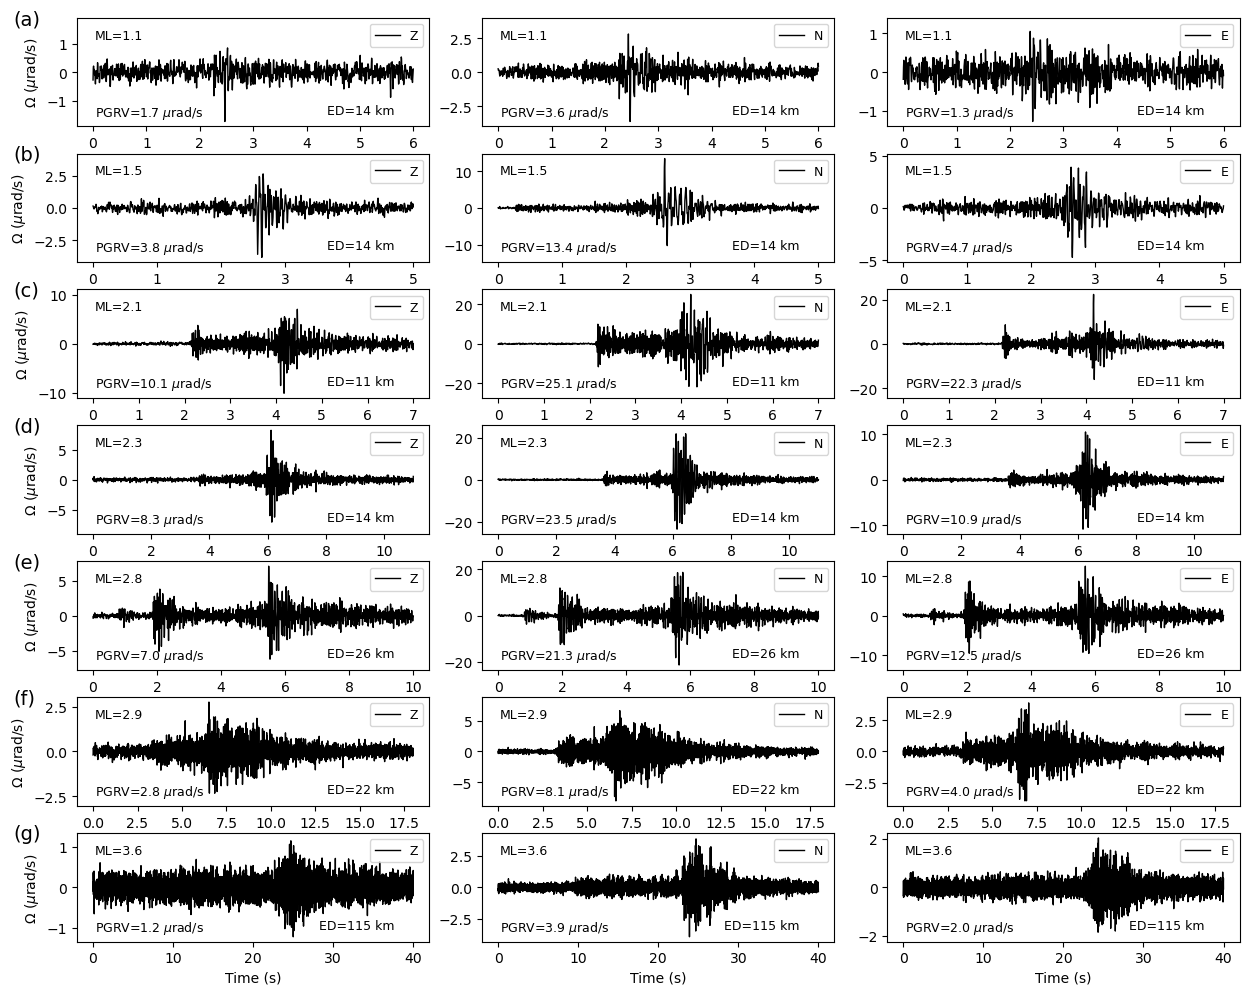

In [8]:
def __makeplot():

    Nrow, Ncol = 7, 3

    font = 12

    rot_scaling, rot_unit = 1e6, f"$\mu$rad/s"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 12))

    plt.subplots_adjust(hspace=0.25, wspace=0.15)

    for _i, _st in enumerate(streams):

        # get rotation rate stream
        rot = _st.select(station="BSPF").copy()

        ## remove mean
        rot = rot.detrend("demean")

        t1 = events[_i]["tbeg"] + events[_i]["trim"][0]
        t2 = events[_i]["tend"] - events[_i]["trim"][1]
        rot = rot.trim(t1, t2)

        amax = np.array([max(abs(rot.select(channel="*Z")[0].data)), max(abs(rot.select(channel="*N")[0].data)), max(abs(rot.select(channel="*E")[0].data))]) *rot_scaling

        ax[_i, 0].plot(rot.select(channel="*Z")[0].times(), rot.select(channel="*Z")[0].data*rot_scaling, "k", label="Z", lw=1.0)
        ax[_i, 1].plot(rot.select(channel="*N")[0].times(), rot.select(channel="*N")[0].data*rot_scaling, "k", label="N", lw=1.0)
        ax[_i, 2].plot(rot.select(channel="*E")[0].times(), rot.select(channel="*E")[0].data*rot_scaling, "k", label="E", lw=1.0)

        for _m in range(Ncol):
            ax[_i, _m].text(0.05, 0.9, f"{events[_i]['Mtype'].upper()}={events[_i]['mag']}", ha='left', va='top',
                            transform=ax[_i, _m].transAxes, fontsize=font-3)
            ax[_i, _m].text(0.9, 0.21, f"ED={int(events[_i]['ED'])} km", ha='right', va='top',
                            transform=ax[_i, _m].transAxes, fontsize=font-3)
            ax[_i, _m].text(0.05, 0.21, f"PGRV={round(amax[_m],1)} {rot_unit}", ha='left', va='top',
                            transform=ax[_i, _m].transAxes, fontsize=font-3)
            ax[_i, _m].set_ylim(-amax[_m]*1.1, amax[_m]*1.1)

    for _m in range(Ncol):
        for _n in range(Nrow):
            # ax[_n, _m].grid(ls=":", zorder=0)
            ax[_n, _m].legend(loc=1, fontsize=font-3)
            ax[_n, 0].set_ylabel(f"$\Omega$ ({rot_unit})")
            ax[Nrow-1, _m].set_xlabel(f"Time (s)")

    ax[0, 0].set_title("")
    ax[0, 1].set_title("")
    ax[0, 2].set_title("")

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']):
        ax[_k, 0].text(-.18, 1.08, ll, ha='left', va='top', transform=ax[_k, 0].transAxes, fontsize=font+2)

    plt.show();
    return fig


fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BSPF_eventselection.png", format="png", dpi=150, bbox_inches='tight');


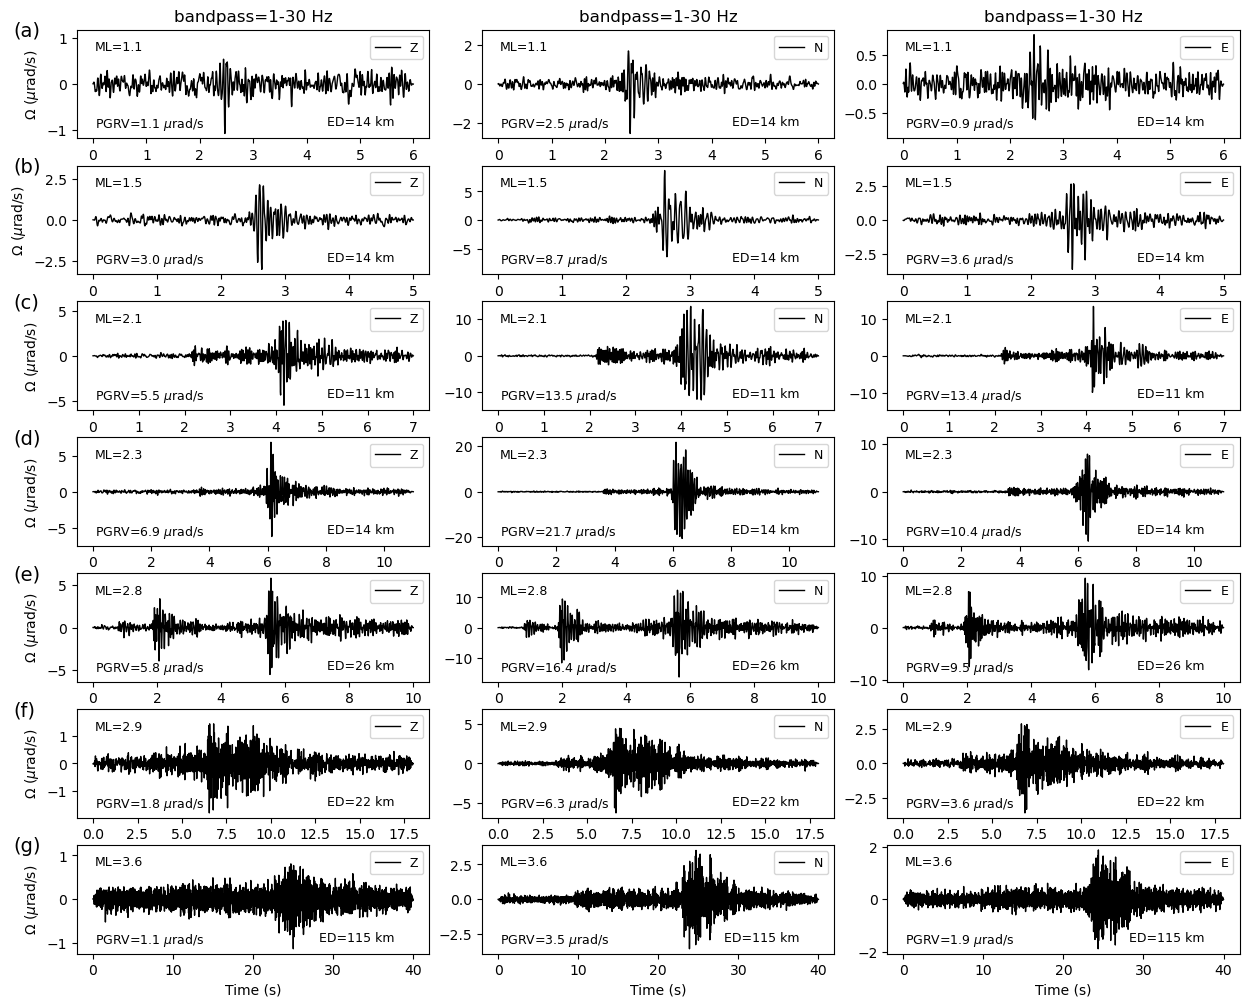

In [9]:
def __makeplot():

    Nrow, Ncol = 7, 3

    font = 12

    rot_scaling, rot_unit = 1e6, f"$\mu$rad/s"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 12))

    plt.subplots_adjust(hspace=0.25, wspace=0.15)

    for _i, _st in enumerate(streams):

        # get rotation rate stream
        rot = _st.select(station="BSPF").copy()

        ## remove mean
        rot = rot.detrend("demean")

        t1 = events[_i]["tbeg"] + events[_i]["trim"][0]
        t2 = events[_i]["tend"] - events[_i]["trim"][1]
        rot = rot.trim(t1, t2)

        rot = rot.taper(0.01)

        fmin, fmax = 1, 30
        rot = rot.filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4)

        amax = np.array([max(abs(rot.select(channel="*Z")[0].data)), max(abs(rot.select(channel="*N")[0].data)), max(abs(rot.select(channel="*E")[0].data))]) *rot_scaling

        ax[_i, 0].plot(rot.select(channel="*Z")[0].times(), rot.select(channel="*Z")[0].data*rot_scaling, "k", label="Z", lw=1.0)
        ax[_i, 1].plot(rot.select(channel="*N")[0].times(), rot.select(channel="*N")[0].data*rot_scaling, "k", label="N", lw=1.0)
        ax[_i, 2].plot(rot.select(channel="*E")[0].times(), rot.select(channel="*E")[0].data*rot_scaling, "k", label="E", lw=1.0)

        for _m in range(Ncol):
            ax[_i, _m].text(0.05, 0.9, f"{events[_i]['Mtype'].upper()}={events[_i]['mag']}", ha='left', va='top',
                            transform=ax[_i, _m].transAxes, fontsize=font-3)
            ax[_i, _m].text(0.9, 0.21, f"ED={int(events[_i]['ED'])} km", ha='right', va='top',
                            transform=ax[_i, _m].transAxes, fontsize=font-3)
            ax[_i, _m].text(0.05, 0.21, f"PGRV={round(amax[_m],1)} {rot_unit}", ha='left', va='top',
                            transform=ax[_i, _m].transAxes, fontsize=font-3)
            ax[_i, _m].set_ylim(-amax[_m]*1.1, amax[_m]*1.1)

    for _m in range(Ncol):
        for _n in range(Nrow):
            # ax[_n, _m].grid(ls=":", zorder=0)
            ax[_n, _m].legend(loc=1, fontsize=font-3)
            ax[_n, 0].set_ylabel(f"$\Omega$ ({rot_unit})")
            ax[Nrow-1, _m].set_xlabel(f"Time (s)")

    ax[0, 0].set_title(f"bandpass={fmin}-{fmax} Hz")
    ax[0, 1].set_title(f"bandpass={fmin}-{fmax} Hz")
    ax[0, 2].set_title(f"bandpass={fmin}-{fmax} Hz")

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']):
        ax[_k, 0].text(-.18, 1.08, ll, ha='left', va='top', transform=ax[_k, 0].transAxes, fontsize=font+2)

    plt.show();
    return fig


fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BSPF_eventselection_bandpass.png", format="png", dpi=150, bbox_inches='tight');
